In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [16]:
data = np.loadtxt("image_test.txt", delimiter=',')
data.shape

(10000, 784)

In [34]:
svd = TruncatedSVD(n_components=100, random_state=0)
X_svd = svd.fit_transform(data)

In [35]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(data)

In [36]:
# assume X is a NumPy array with dtype float
X_svd = X_svd.astype(np.float64)
# Apply t-SNE for further dimensionality reduction

# initialize t-SNE model
tsne = TSNE(n_components=2, perplexity=50, learning_rate=300, n_iter=5000, n_jobs=4, square_distances=True, metric='cosine')

# fit and transform data with t-SNE
X_tsne = tsne.fit_transform(X_svd)

/Users/chaithrabekal/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [46]:
class KMeansClustering():
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, n_runs=10):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.n_runs = n_runs
        self.cluster_labels = None
        self.best_cluster_labels = None
        self.best_inertia = None

    def initialize_centroids(self, X):
        centroid_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        centroids = X[centroid_indices]
        return centroids

    def compute_distances(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return distances

    def assign_clusters(self, X, centroids):
        distances = self.compute_distances(X, centroids)
        cluster_labels = np.argmin(distances, axis=1)
        return cluster_labels

    def update_centroids(self, X, cluster_labels):
        centroids = np.array([X[cluster_labels == k].mean(axis=0) for k in range(self.n_clusters)])
        return centroids

    def fit(self, X_tsne):
        
        all_cluster_labels = []
        all_inertias = []
        for run in range(self.n_runs):
            centroids = self.initialize_centroids(X_tsne)
            for iteration in range(self.max_iter):
                initial_centroids = centroids.copy()
                cluster_labels = self.assign_clusters(X_tsne, centroids)
                centroids = self.update_centroids(X_tsne, cluster_labels)
                change_in_centroids = np.sqrt(np.sum((centroids - initial_centroids) ** 2, axis=1))

                # check for convergence
                if np.max(change_in_centroids) < self.tol:
                    break
            all_cluster_labels.append(cluster_labels)
            # Calculate inertia for the current run
            inertia = np.sum([np.sum(np.linalg.norm(X_tsne[cluster_labels == k] - centroids[k], axis=1) ** 2) for k in range(self.n_clusters)])
            all_inertias.append(inertia)

        # Pick the best cluster labels based on the lowest inertia
        best_run_idx = np.argmin(all_inertias)
        self.cluster_labels = np.array(all_cluster_labels)
        self.best_cluster_labels = self.cluster_labels[best_run_idx]
        self.best_inertia = all_inertias[best_run_idx]

        return self.best_cluster_labels, self.best_inertia

In [47]:
def plotting(X, labels):
    fig = plt.figure(figsize=(10, 10))
    axs = fig.add_subplot()
    axs.scatter(X[:,0], X[:,1], c=labels)
    axs.set_title("K-Means Clustering with t-SNE Dimensionality Reduction")
    plt.show()

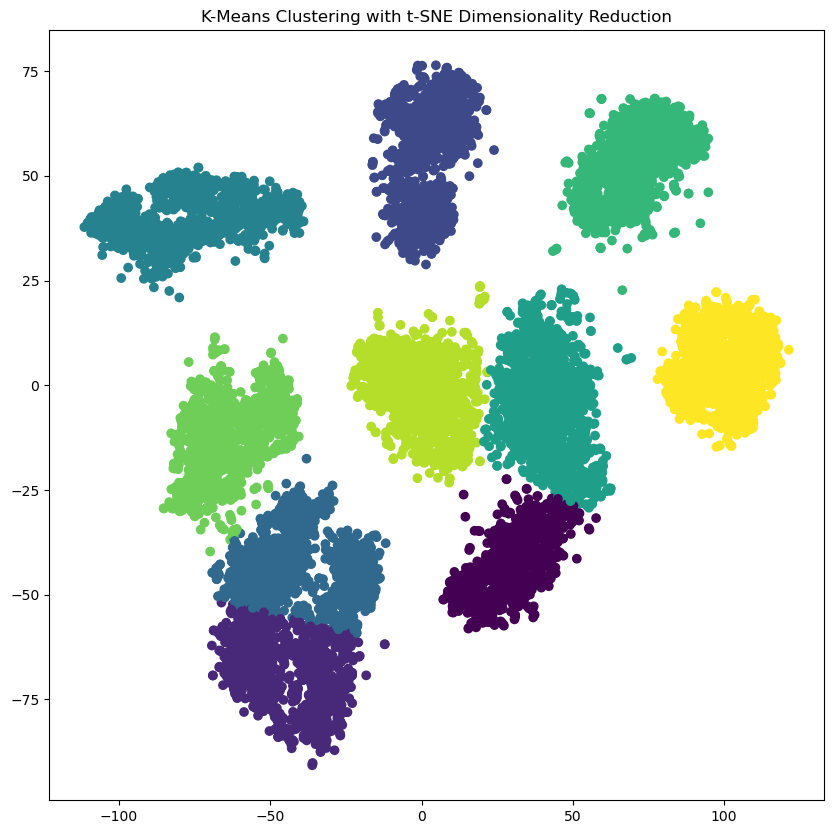

       0
0      9
1     10
2      8
3      4
4      7
...   ..
9995   7
9996   9
9997   8
9998   4
9999   9

[10000 rows x 1 columns]


In [48]:
kmeans = KMeansClustering(n_clusters=10, max_iter=300, tol=1e-4, n_runs=100)
predictions = kmeans.fit(X_tsne)
plotting(X_tsne, predictions[0])
predictions = pd.DataFrame(predictions[0])
predictions = predictions.replace({0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10})
print(predictions)

In [45]:
predictions.to_csv('predictionssvdpcatsne100.csv', index=False, header=False, escapechar=None)

In [49]:
best_inertias=[]
for k in range(2, 21, 2):
    km = KMeansClustering(n_clusters=k, max_iter=300, tol=1e-4, n_runs=100)
    predictions = km.fit(X_tsne)
    print(predictions[1])
    best_inertias.append(predictions[1])

23667148.0
10822826.0
5826860.5
3334104.5
2294619.0
1815077.4
1535492.0
1329760.0
1171755.2
1010106.1


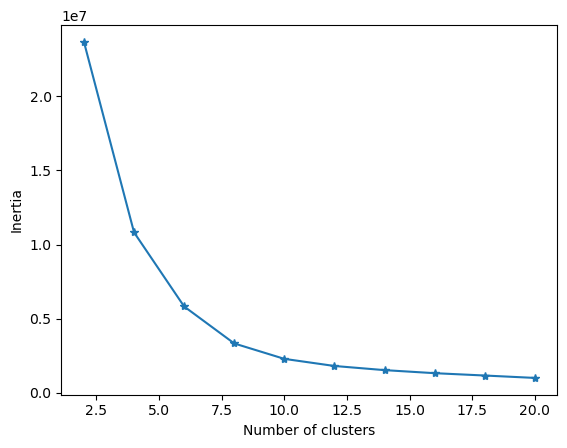

In [50]:
import matplotlib.pyplot as plt

plt.plot(range(2, 21, 2), best_inertias, marker="*")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()